In [1]:
# first, load the embeddings
# stored in torch tensors

import torch
import numpy as np
import os
import sys
import json
import argparse
import time
import random
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import scipy.stats 

embeddings_folder = '../data/cifar-10-embedding-3/embeddings/' 
embeddings_files = sorted(os.listdir(embeddings_folder))
test_embeddings = torch.load(embeddings_folder + embeddings_files[0]) # load the first file
print(test_embeddings.size()) # 128, 32, 32, 32

# calculate the entropy of the embeddings, select 1%, 5%, 10%, 20%, 50% of the embeddings
def calculate_entropy(embs, percentage):
    # embs are torch tensors
    # percentage shows the number of embeddings to select
    embs_entropy = []
    for i in range(embs.size(len(embs.size())-3)):
        embs_entropy.append(scipy.stats.entropy(embs[:, i].reshape(-1))) # b, c
    # get the top percentage of the channels
    embs_entropy = np.array(embs_entropy)
    indices = np.argsort(embs_entropy)
    num_selected = int(embs.size(1) * percentage)
    selected_indices = indices[:num_selected]
    return selected_indices
    # out b, c*p, h, w or c*p, h, w

def ranker_entropy(embs, percentage):
    # calculate the entropy of the embeddings
    selected_indices = calculate_entropy(embs, percentage)
    # select indice from test embeddings
    selected_embeddings = embs[:, selected_indices] # b, c*p, h, w
    return selected_embeddings

# get the selected embeddings
selected_embeddings = ranker_entropy(test_embeddings, 0.1)
print(selected_embeddings.size())


torch.Size([128, 32, 32, 32])
torch.Size([128, 3, 32, 32])


In [13]:
from scipy.stats import entropy
a = torch.tensor([0.1, 0.2, 0.3, 0.4])
print(entropy(a))
a = torch.tensor([0.1, 0.2, 0.3, 0.5])
print(entropy(a))
a = torch.tensor([0.1, 0.4, 0.3, 0.5])
print(entropy(a))

1.2798543
1.2406843
1.2658567


In [6]:
# embeddings_folder = '../data/cifar-10-embedding-3/embeddings/' 
selected_embeddings.shape

torch.Size([128, 3, 32, 32])

In [8]:
embeddings_folder = '../data/cifar-10-embedding-3/embeddings/' 
embeddings_files = sorted(os.listdir(embeddings_folder))
test_embeddings = torch.load(embeddings_folder + embeddings_files[0]) # load the first file

8
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(8)


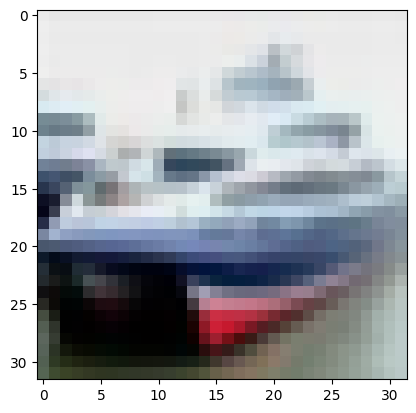

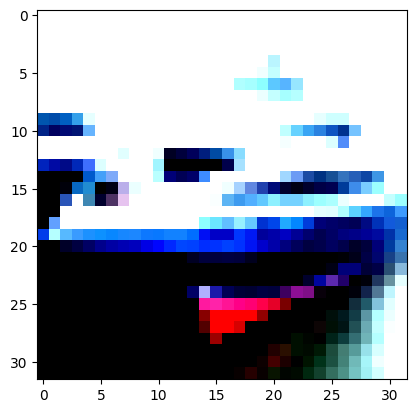

In [94]:
import matplotlib.pyplot as plt
# load a picture
figure_folder = '/home/tonypeng/Workspace1/adaptfilter/data/cifar-10-batches-py/test_batch'
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
cifar_data = unpickle(figure_folder)
figure0 = cifar_data[b'data'][1].reshape(3,32,32)
label0 = cifar_data[b'labels'][1]
# print figure0
plt.figure()
plt.imshow(figure0.transpose(1, 2, 0))
print(label0)

# plot figure0
import torchvision.transforms as transforms
import torchvision
transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
testset = torchvision.datasets.CIFAR10(
        root='/home/tonypeng/Workspace1/adaptfilter/data/', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
        testset, batch_size=100, shuffle=False, num_workers=4)
for i, data in enumerate(testloader):
    figure0, label0 = data
    break

# plot figure0
plt.figure()
plt.imshow(figure0[1].numpy().transpose(1, 2, 0))
print(label0[1])
# figure0 = figure0[1].unsqueeze(0)
# label0 = label0[1]

In [98]:
# import model
from Models import mobilenetv2

client_model, server_model = mobilenetv2.stupid_model_splitter(weight_path='./Weights/cifar-10/MobileNetV2.pth')
features0 = client_model(figure0)
result = server_model(features0)
# get the index
result = torch.argmax(result, dim=1)
print(result)
print(label0)
print(result-label0)

# test split performance
result2 = []
for i in range(100):
    features0 = client_model(figure0[i].unsqueeze(0))
    result = server_model(features0)
    result = torch.argmax(result, dim=1)
    result2.append(result)
result2 = torch.tensor(result2)
print(result2)
print(result2-label0)

tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 4, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9,
        5, 2, 4, 0, 9, 6, 6, 5, 4, 5, 9, 3, 4, 1, 9, 5, 4, 6, 3, 6, 0, 9, 3, 0,
        7, 6, 9, 8, 7, 3, 8, 8, 7, 3, 5, 3, 7, 5, 3, 3, 6, 2, 3, 2, 5, 7, 2, 6,
        8, 8, 0, 2, 9, 3, 3, 8, 8, 1, 1, 7, 2, 0, 2, 7, 8, 9, 0, 3, 8, 6, 4, 6,
        6, 0, 0, 7])
tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9,
        5, 2, 4, 0, 9, 6, 6, 5, 4, 5, 9, 2, 4, 1, 9, 5, 4, 6, 5, 6, 0, 9, 3, 9,
        7, 6, 9, 8, 0, 3, 8, 8, 7, 7, 4, 6, 7, 3, 6, 3, 6, 2, 1, 2, 3, 7, 2, 6,
        8, 8, 0, 2, 9, 3, 3, 8, 8, 1, 1, 7, 2, 5, 2, 7, 8, 9, 0, 3, 8, 6, 4, 6,
        6, 0, 0, 7])
tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,
         0,  0,  0,  0,  0,  0, -2,  0,  0,  0,  0, -9,  0,  0,  0,  0,  7,  0,
         0,  0,  0, -4,  1, -3,  0,  2, -3,  0,  0,  0,  2,  0,  2,  0,  0,  0